* https://qiita.com/nozma/items/0025ce9e84ffbc7b18c2

Juliaを使う人はまず最初に

* https://docs.julialang.org/en/v1/manual/performance-tips/

を読むべき.  私はこれを見つけたときに「どうして最初にこれの存在を教えてくれなかったんだよ！」と嘆きました.  これを最初に読んでおけば大幅に時間の無駄を削減できた.

 31.375216 seconds (77.14 M allocations: 27.612 GiB, 26.36% gc time, 12.54% compilation time)


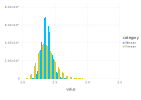

Main.Original

In [1]:
module Original

using Statistics
using DataFrames
using Gadfly

n = 1000000
N = 1000
p = 0.3
t = 2

function mfmean()
    M = randn(N)
    F = randn(N)
    f = F[F .> t]
    Mmean = mean(M[M .> t])
    Fmean = mean(f[1:Int(round(length(f)*p))])
    return DataFrame(
        category = ["Mmean", "Fmean"],
        value = [Mmean, Fmean]
    )
end

@time result = vcat([mfmean() for i in 1:n]...)
plot(result, x = "value", color = "category", Geom.histogram(bincount = 120, position = :dodge)) |> display

end

 11.957778 seconds (10.00 M allocations: 24.010 GiB, 16.20% gc time)


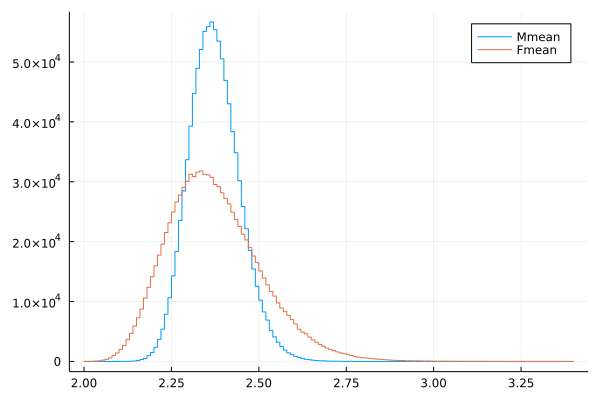

Main.RevisedVersion1

In [2]:
module RevisedVersion1

using Statistics
using DataFrames
using Plots

function mfmean(; n = 10^6, N = 10^3, p = 0.3, t = 2)
    Mmean = Vector{Float64}(undef, n)
    Fmean = similar(Mmean)
    for i in 1:n
        M = randn(N)
        F = randn(N)
        f = F[F .> t]
        Mmean[i] = mean(M[M .> t])
        Fmean[i] = mean(@view f[1:round(Int, length(f)*p)])
    end
    Mmean, Fmean
end

@time Mmean, Fmean = mfmean()
stephist([Mmean Fmean]; bin=2:0.01:3.4, label=["Mmean" "Fmean"]) |> display

end

  6.218395 seconds (6 allocations: 15.274 MiB)


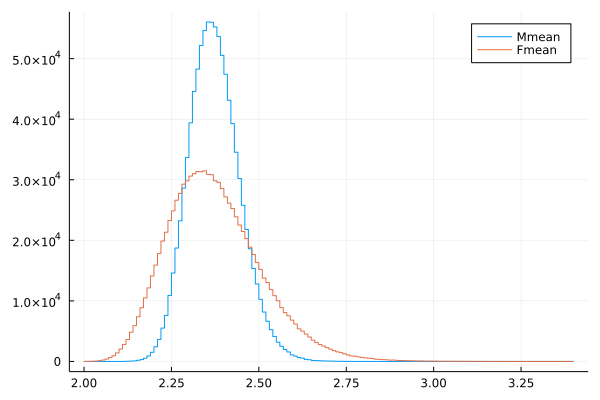

Main.RevisedVersion2

In [3]:
module RevisedVersion2

using Random
using Statistics
using DataFrames
using Plots

function restrict_greater_than!(X, t)
    n = firstindex(X) - 1
    @inbounds for i in eachindex(X)
        if X[i] > t
            n += 1
            X[n] = X[i]
        end
    end
    n
end

function mfmean(; n = 10^6, N = 10^3, p = 0.3, t = 2)
    Mmean = Vector{Float64}(undef, n)
    Fmean = similar(Mmean)
    Mtmp = Vector{Float64}(undef, N)
    Ftmp = similar(Mtmp)
    for i in 1:n
        M = randn!(Mtmp)
        F = randn!(Ftmp)
        endofM = restrict_greater_than!(M, t)
        Mmean[i] = endofM < firstindex(M) ? 0.0 : mean(@view M[begin:endofM])
        endofF = restrict_greater_than!(F, t)
        endofF = round(Int, endofF*p)
        Fmean[i] = endofF < firstindex(F) ? 0.0 : mean(@view F[begin:endofF])
    end
    Mmean, Fmean
end

@time Mmean, Fmean = mfmean()
stephist([Mmean Fmean]; bin=2:0.01:3.4, label=["Mmean" "Fmean"]) |> display

end

  1.280966 seconds (175.96 k allocations: 24.859 MiB, 5.56% compilation time)


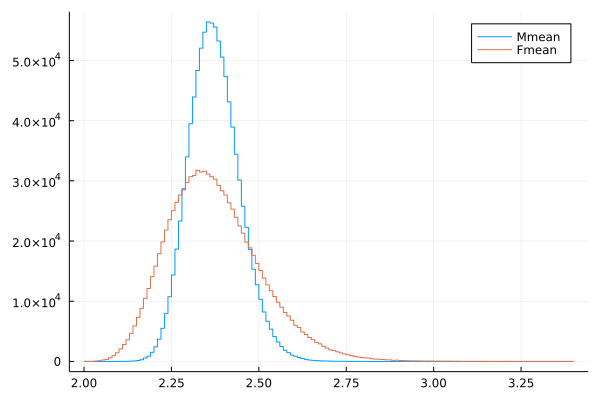

Main.RevisedVersion3

In [4]:
module RevisedVersion3

using Random
using Base.Threads
using Statistics
using DataFrames
using Plots

function restrict_greater_than!(X, t)
    n = firstindex(X) - 1
    @inbounds for i in eachindex(X)
        if X[i] > t
            n += 1
            X[n] = X[i]
        end
    end
    n
end

function mfmean(; n = 10^6, N = 10^3, p = 0.3, t = 2)
    Mmean = Vector{Float64}(undef, n)
    Fmean = similar(Mmean)
    Mtmp = [Vector{Float64}(undef, N) for _ in 1:nthreads()]
    Ftmp = [Vector{Float64}(undef, N) for _ in 1:nthreads()]
    @threads for i in 1:n
        M = randn!(Mtmp[threadid()])
        F = randn!(Ftmp[threadid()])
        endofM = restrict_greater_than!(M, t)
        Mmean[i] = endofM < firstindex(M) ? 0.0 : mean(@view M[begin:endofM])
        endofF = restrict_greater_than!(F, t)
        endofF = round(Int, endofF*p)
        Fmean[i] = endofF < firstindex(F) ? 0.0 : mean(@view F[begin:endofF])
    end
    Mmean, Fmean
end

@time Mmean, Fmean = mfmean()
stephist([Mmean Fmean]; bin=2:0.01:3.4, label=["Mmean" "Fmean"]) |> display

end